In [1]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import random
np.random.seed(0)
im = np.load('1.npy')
im1 = np.load('1.npy')

# stack along x axis
stack_arr = [im,im1]
im_comp = np.stack(stack_arr,axis=1)
im_comp=np.concatenate((im,im1))
im_comp.shape

snow = ps.networks.snow2(
    phases=im_comp,
    phase_alias={True:"void",False:"solid"},
    voxel_size=2.32e-06)

##### You need to add boundary faces from extracted network
ws = op.Workspace()

pn = op.io.network_from_porespy(snow.network)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
proj = pn.project

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1379 [00:00<?, ?it/s]

In [2]:
boundary_ps_num = 30
idx_min = pn['pore.coords'][:,0].argsort()[:boundary_ps_num]
idx_max = pn['pore.coords'][:,0].argsort()[-boundary_ps_num:]
pn.set_label(label='left',pores=idx_min)
pn.set_label(label='right',pores=idx_max)

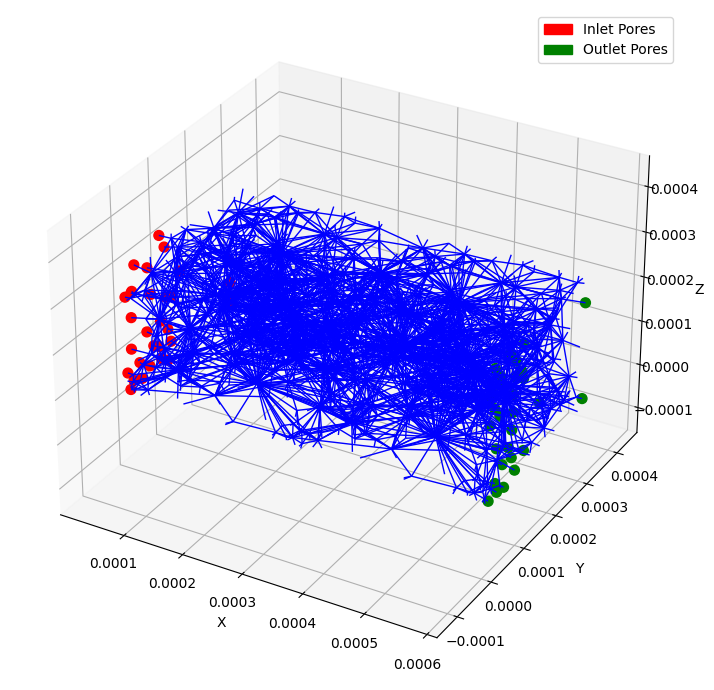

In [3]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Inlet Pores')
green_patch = mpatches.Patch(color='green', label='Outlet Pores')

fig, ax = plt.subplots(figsize=(7, 7))
op.visualization.plot_connections(network=pn, ax=ax)
op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), 
                                    markersize=50, ax=ax, c='r')
op.visualization.plot_coordinates(network=pn, pores=pn.pores('right'), 
                                    markersize=50, ax=ax, c='g')
# plt.axis('off')
plt.legend(handles=[red_patch,green_patch])

#### Percolation

In [4]:
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

Text(0, 0.5, 'Non-Wetting Phase Saturation')

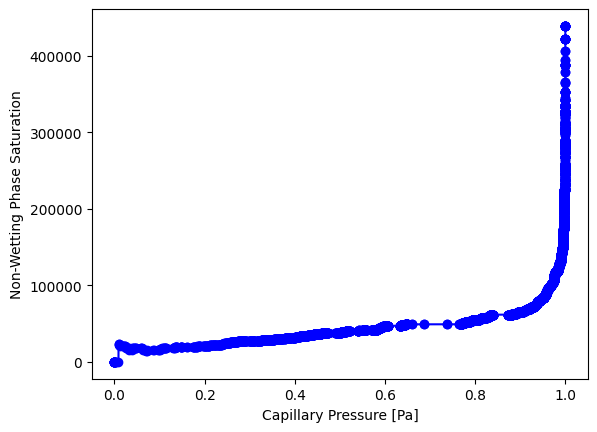

In [5]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('left')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

# plot the intrusion curve
data = ip.pc_curve()
f = plt.figure()
plt.plot(data.snwp, data.pc, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation')

In [6]:
# ip.set_outlet_BC(pores=pn.pores('right'),mode='overwrite')
# ip.apply_trapping()
# data2 = ip.pc_curve()
# f = plt.figure()
# plt.plot(data.snwp, data.pc, 'b-o',label='without trapping')
# plt.plot(data2.snwp, data2.pc, 'r-o',label='with trapping')
# plt.xlabel('Capillary Pressure [Pa]')
# plt.ylabel('Non-Wetting Phase Saturation')
# plt.legend()

In [7]:
def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('left')
flow_out = pn.pores('right')
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
# %%
Snwp_num=100
flow_in = pn.pores('left')
flow_out = pn.pores('right')
max_seq = np.max([np.max(ip['pore.invasion_sequence']),
          np.max(ip['throat.invasion_sequence'])])
start = 0
stop = max_seq
step = max_seq//Snwp_num
Snwparr = []
relperm_nwp = []
relperm_wp = []

for i in range(start, stop, step):
    air.regenerate_models()
    water.regenerate_models()
    sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
    Snwparr.append(sat)
    Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
    relperm_wp.append(Rate_ewp/Rate_abs_wp)


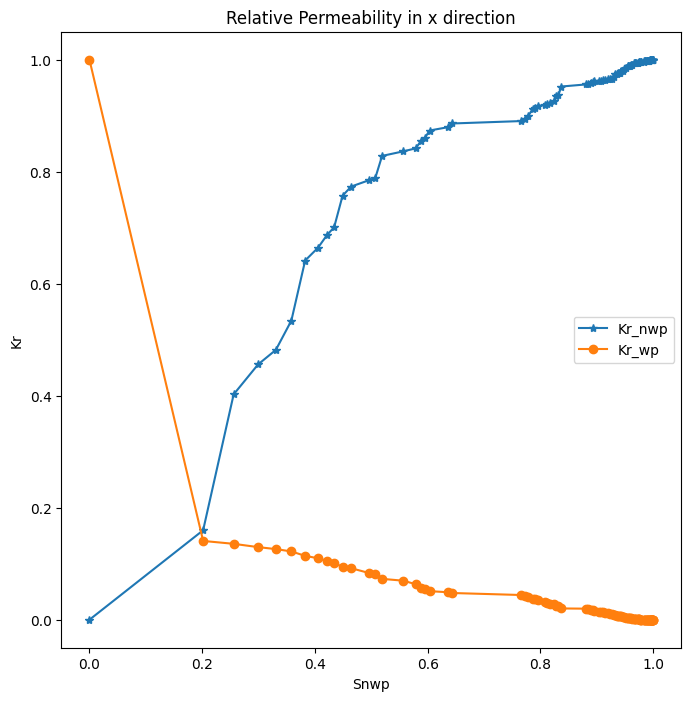

In [8]:
plt.figure(figsize=[8,8])
plt.plot(Snwparr, relperm_nwp, '*-', label='Kr_nwp')
plt.plot(Snwparr, relperm_wp, 'o-', label='Kr_wp')
plt.xlabel('Snwp')
plt.ylabel('Kr')
plt.title('Relative Permeability in x direction')
plt.legend()

In [9]:
ps.metrics.porosity( im_comp )

0.17746496200561523

In [15]:
voxel_size=2.32e-06
volume = 128*voxel_size *(128*voxel_size)*(256*voxel_size)
np.sum(pn['pore.volume'])/volume

10941002876.78343

In [16]:
volume

5.237497869107199e-11